<a href="https://colab.research.google.com/github/eli-vigneron/Deep-Learning-Pytorch/blob/main/neural_collapse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal**<br>
The goal of this is to train a ResNet18 model on MNIST and to track throughout the epochs of SGD the convergence to Neural Collapse.


*Requires including a GPU in the runtime*


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

from scipy.sparse.linalg import svds
from torchvision import datasets, transforms

%matplotlib inline

In [ ]:
# hyperparameters
device          = "cuda"
epochs          = 32
lr              = 0.0679
batch_size      = 128
momentum        = 0.9
weight_decay    = 5e-4
C               = 10

In [ ]:
# deep network
model = models.resnet18(pretrained=False, num_classes=10)
model.conv1 = nn.Conv2d(1, model.conv1.weight.shape[0], 3, 1, 1, bias=False)
model.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0)
model = model.to(device)

class features:
    pass

def hook(self, input, output):
    features.value = input[0].clone()

# register hook that saves last-layer input into features
classifier = model.fc
classifier.register_forward_hook(hook)

# dataset loaders
transform = transforms.Compose([transforms.Pad(2),
                                transforms.ToTensor(),
                                transforms.Normalize(0.1307,0.3081)])

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', download=True, train=True, transform=transform), 
    batch_size=batch_size, shuffle=True, drop_last=True)

# loss function
loss_function = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)

# learning rate scheduler
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                              milestones=[epochs//3, (epochs*3)//3],
                                              gamma=0.1)


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
Sw_invSb = []
norm_M_CoV = []
cos_M = []
W_M_dist = []

# iterate over epochs
for epoch in range(1, epochs+1):
    # train phase
    model.train()
    accuracy = 0
    N = 0

    # iterate over train data
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        logits = model(images)
        loss = loss_function(logits, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(logits,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]

        print('Train\t\tEpoch: {} \t'
              'Batch {}/{} ({:.0f}%) \t'
              'Batch Loss: {:.6f} \t'
              'Batch Accuracy: {:.6f}'.format(
                  epoch,
                  batch_idx,
                  len(train_loader),
                  100. * batch_idx / len(train_loader),
                  loss.item(),
                  100. * accuracy/N))
    lr_scheduler.step()

    model.eval()

    mean = [0 for _ in range(C)]
    Sw = 0
    examples_in_class = [0 for _ in range(C)]

    for computation in ['Mean','Cov']:
        for batch_idx, (data, labels) in enumerate(train_loader, start=1):
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            h = features.value.data.view(data.shape[0],-1) # B CHW
    
            for c in range(C):
                # TASK: ADD CODE HERE

                for i, label in enumerate(labels):
                    ave_i = torch.mean(data[i])
                    if label == c:
                        
                        h_ic = h[i] 
                        mu_c = ave_i*h_ic
                        hmu = h_ic - mu_c
                        hmu = hmu.view(512,1)
                      
                        if computation == 'Mean':
                            # TASK: ADD CODE HERE
                            examples_in_class[c] += 1 
                            mean[c] += mu_c
              
                        elif computation == 'Cov':
                            # TASK: ADD CODE HERE
                            ave_ic = torch.mean(data[i])
                            Sw += ave_ic * torch.matmul(hmu, hmu.T)
    

        # normalize the sum by the number of contributions
        if computation == 'Mean':
            for c in range(C):
                mean[c] /= examples_in_class[c]
                M = torch.stack(mean).T
        elif computation == 'Cov':
            Sw /= sum(examples_in_class)
    
    # global mean
    muG = torch.mean(M, dim=1, keepdim=True) # CHW 1
    
    # between-class covariance
    M_ = M - muG
    Sb = torch.matmul(M_, M_.T) / C

    # NC1: activation collapse
    Sw = Sw.cpu().numpy()
    Sb = Sb.cpu().numpy()
    eigvec, eigval, _ = svds(Sb, k=C-1)
    inv_Sb = eigvec @ np.diag(eigval**(-1)) @ eigvec.T 
    Sw_invSb.append(np.trace(Sw @ inv_Sb) / C)

    # NC2: convergence of class means to Simplex ETF
    M_norms = torch.norm(M_,  dim=0)
    norm_M_CoV.append((torch.std(M_norms)/torch.mean(M_norms)).item())

    def coherence(V): 
        G = V.T @ V
        G += torch.ones((C,C),device=device) / (C-1)
        G -= torch.diag(torch.diag(G))
        return torch.norm(G,1).item() / (C*(C-1))
    cos_M.append(coherence(M_/M_norms))

    # NC3: self duality
    W  = classifier.weight
    normalized_M = M_ / torch.norm(M_,'fro')
    normalized_W = W.T / torch.norm(W.T,'fro')
    W_M_dist.append((torch.norm(normalized_W - normalized_M)**2).item())

Train		Epoch: 1 	Batch 1/468 (0%) 	Batch Loss: 0.070076 	Batch Accuracy: 97.656250
Train		Epoch: 1 	Batch 2/468 (0%) 	Batch Loss: 0.082495 	Batch Accuracy: 97.265625
Train		Epoch: 1 	Batch 3/468 (1%) 	Batch Loss: 0.108137 	Batch Accuracy: 97.135417
Train		Epoch: 1 	Batch 4/468 (1%) 	Batch Loss: 0.114839 	Batch Accuracy: 96.679688
Train		Epoch: 1 	Batch 5/468 (1%) 	Batch Loss: 0.032997 	Batch Accuracy: 97.187500
Train		Epoch: 1 	Batch 6/468 (1%) 	Batch Loss: 0.092346 	Batch Accuracy: 97.265625
Train		Epoch: 1 	Batch 7/468 (1%) 	Batch Loss: 0.114854 	Batch Accuracy: 96.875000
Train		Epoch: 1 	Batch 8/468 (2%) 	Batch Loss: 0.062138 	Batch Accuracy: 97.167969
Train		Epoch: 1 	Batch 9/468 (2%) 	Batch Loss: 0.059308 	Batch Accuracy: 97.309028
Train		Epoch: 1 	Batch 10/468 (2%) 	Batch Loss: 0.072094 	Batch Accuracy: 97.343750
Train		Epoch: 1 	Batch 11/468 (2%) 	Batch Loss: 0.120552 	Batch Accuracy: 97.088068
Train		Epoch: 1 	Batch 12/468 (3%) 	Batch Loss: 0.086014 	Batch Accuracy: 97.070312
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in reciprocal
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in matmul


Streaming output truncated to the last 5000 lines.
Train		Epoch: 22 	Batch 149/468 (32%) 	Batch Loss: 0.001267 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 150/468 (32%) 	Batch Loss: 0.001305 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 151/468 (32%) 	Batch Loss: 0.001696 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 152/468 (32%) 	Batch Loss: 0.001297 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 153/468 (33%) 	Batch Loss: 0.002193 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 154/468 (33%) 	Batch Loss: 0.001565 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 155/468 (33%) 	Batch Loss: 0.001622 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 156/468 (33%) 	Batch Loss: 0.001291 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 157/468 (34%) 	Batch Loss: 0.001257 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 158/468 (34%) 	Batch Loss: 0.002628 	Batch Accuracy: 100.000000
Train		Epoch: 22 	Batch 159/468 (34%) 	Batch Loss: 0.001758 	Batch Ac

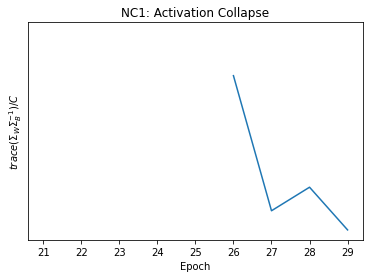

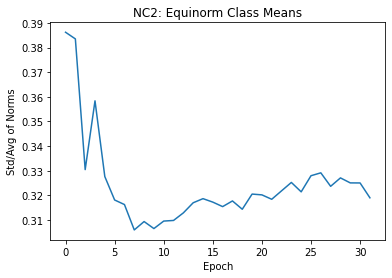

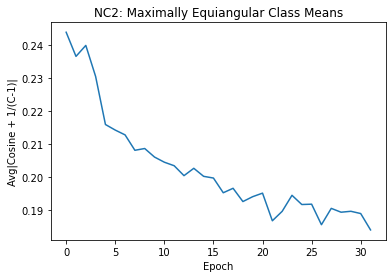

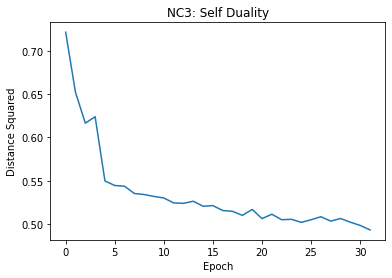

In [ ]:
plt.figure(1)
plt.semilogy(Sw_invSb)
plt.yscale('symlog')
plt.xlabel('Epoch')
plt.ylabel('$trace(\Sigma_W \Sigma_B^{-1}) / C$')
plt.title('NC1: Activation Collapse')

plt.figure(2)
plt.plot(norm_M_CoV)
plt.xlabel('Epoch')
plt.ylabel('Std/Avg of Norms')
plt.title('NC2: Equinorm Class Means')

plt.figure(3)
plt.plot(cos_M)
plt.xlabel('Epoch')
plt.ylabel('Avg|Cosine + 1/(C-1)|')
plt.title('NC2: Maximally Equiangular Class Means')

plt.figure(4)
plt.plot(W_M_dist)
plt.xlabel('Epoch')
plt.ylabel('Distance Squared')
plt.title('NC3: Self Duality')

plt.show()